#Global Rainfall Rate Prediction

### Importing Modules and Loading Data

In [ ]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

In [ ]:
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Global = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Global.csv', index_col=[0,1])
Global.head()

1998-01-01  1998-01-02  ...  2019-12-29  2019-12-30
59.875 4.875       21.69        2.55  ...         0.0        0.48
       5.125       17.79        6.75  ...         0.0        0.18
       5.375       10.92        5.88  ...         0.0        0.00
       5.625        6.24        9.60  ...         0.0        0.00
       5.875       14.52       18.66  ...         0.0        0.00

[5 rows x 8031 columns]

######Description of Data

We can get the timeseries of any day by like this

In [ ]:
## Find data for lat-lon
Global.loc[(59.875,4.875)]

1998-01-01    21.69
1998-01-02     2.55
1998-01-03     0.00
1998-01-04     2.34
1998-01-05    93.72
              ...  
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.48
Name: (59.875, 4.875), Length: 8031, dtype: float64

## Automatic Latitude-Longitude Generation

Dataframe is generated automatically if Location name/ co-ordinates are provided. Manual option is also included.

In [ ]:
def get_city_coordinates():
  from geopy.geocoders import Nominatim
  geolocator = Nominatim(user_agent="my_user_agent")
  city =input('**HIT ENTER for Manual Mode **OR**\nEnter Location As "City" or "City, Country" format: ')
  country =""
  loc = geolocator.geocode(city+','+ country)
  print("latitude is " ,loc.latitude,"&longtitude is " ,loc.longitude)
  return loc.latitude,loc.longitude

In [ ]:
## Findout closest coordinates wrt to available data
def closest(pos):
    latitude = pos[0]
    longitude = pos[1]
    lon = [59.875 + 0.25*x for x in range(161)]
    lat = [4.875 + 0.25*x for x in range(121)]
    LAT = lat[min(range(len(lat)), key = lambda i: abs(lat[i]-latitude))]
    LON = lon[min(range(len(lon)), key = lambda i: abs(lon[i]-longitude))]
    if (abs(latitude-LAT) > 1) or (abs(longitude-LON)>1):
        return 0
    return (LON,LAT)

In [ ]:
## Handles error and facilitates manual insersion
def GetLocation():
  try:
    x = closest(get_city_coordinates())
  except AttributeError:
    print("\nEntering Manual Mode")
    def Manual():
      # nonlocal x
      lat = float(input("Enter Latitude: "))
      lon = float(input("Enter Longitude: "))
      y = closest((lat,lon))
      if y==0:
        print('No Data Found, Try Again with other locations\n')
        y = Manual()
      # else:
      #   # print(y)
      return y
    x = Manual()
    # print(x)

  finally:
    if x==0:
        print('No Data Found for this City. Try Again with other Cities.\n')
        df = GetLocation()
    else:
        df = pd.DataFrame(Global.loc[x])
        print(f"Table Created with nearest co-ordinates: {x}")
        df.columns = ['Rainfall']
        display(df)
    return df

###### Run this cell to get Latitude & Longitude

**HIT ENTER for Manual Mode **OR**
Enter Location As "City" or "City, Country" format: kolkata
latitude is  22.5414185 &longtitude is  88.35769124388872
Table Created with nearest co-ordinates: (88.375, 22.625)


,Rainfall
1998-01-01,0.0000
1998-01-02,0.0000
1998-01-03,0.0000
1998-01-04,4.8600
1998-01-05,0.0000
...,...
2019-12-26,0.0000
2019-12-27,0.0000
2019-12-28,0.0000
2019-12-29,5.0818


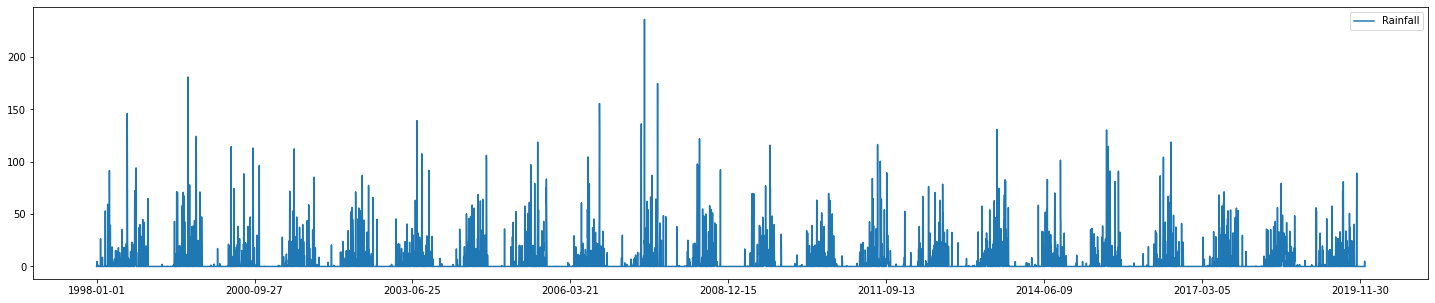

In [ ]:
## Run this function to create DataFrame
df = GetLocation()
df.plot(figsize=(25,5))

## MODEL 1: Using FB Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
model=Prophet(yearly_seasonality=True, weekly_seasonality=True)

In [ ]:
df_fb = df.reset_index()
df_fb.columns = ['ds','y']
df_fb.head()

,ds,y
0,1998-01-01,0.00
1,1998-01-02,0.00
2,1998-01-03,0.00
3,1998-01-04,4.86
4,1998-01-05,0.00


In [ ]:
df_fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8031 entries, 0 to 8030
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      8031 non-null   object 
 1   y       8031 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.6+ KB


In [ ]:
model.fit(df_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
future_dates=model.make_future_dataframe(periods=365)

In [ ]:
future_dates.tail()

,ds
8391,2020-12-25
8392,2020-12-26
8393,2020-12-27
8394,2020-12-28
8395,2020-12-29


In [ ]:
prediction=model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-01-01,4.967563,-16.260125,16.985936,4.967563,4.967563,-5.062022,-5.062022,-5.062022,-0.469888,-0.469888,-0.469888,-4.592134,-4.592134,-4.592134,0.0,0.0,0.0,-0.094459
1,1998-01-02,4.967505,-14.988930,17.330285,4.967505,4.967505,-4.365154,-4.365154,-4.365154,0.159140,0.159140,0.159140,-4.524294,-4.524294,-4.524294,0.0,0.0,0.0,0.602352
2,1998-01-03,4.967448,-16.384711,16.779965,4.967448,4.967448,-4.683229,-4.683229,-4.683229,-0.227896,-0.227896,-0.227896,-4.455333,-4.455333,-4.455333,0.0,0.0,0.0,0.284219
3,1998-01-04,4.967390,-15.815474,18.348181,4.967390,4.967390,-4.119051,-4.119051,-4.119051,0.268180,0.268180,0.268180,-4.387231,-4.387231,-4.387231,0.0,0.0,0.0,0.848340
4,1998-01-05,4.967333,-15.406829,16.874674,4.967333,4.967333,-4.217302,-4.217302,-4.217302,0.104630,0.104630,0.104630,-4.321932,-4.321932,-4.321932,0.0,0.0,0.0,0.750031


In [ ]:
# model.plot(prediction)

Text(0.5, 1.0, 'Prediction for ONE YEAR after 2019')

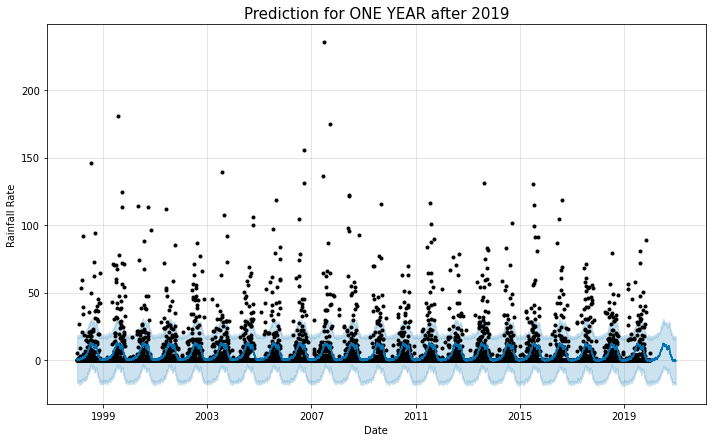

In [ ]:
fig = model.plot(prediction, xlabel='Date', ylabel='Rainfall Rate')
ax = fig.gca()
ax.set_title("Prediction for ONE YEAR after 2019", size=15)

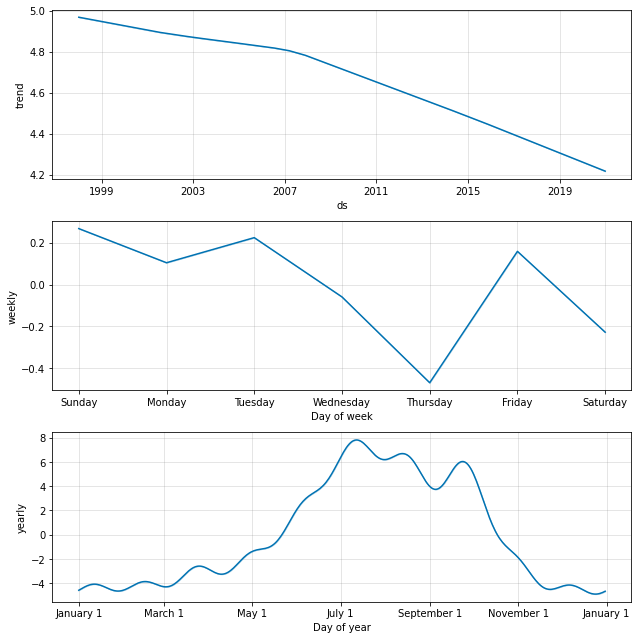

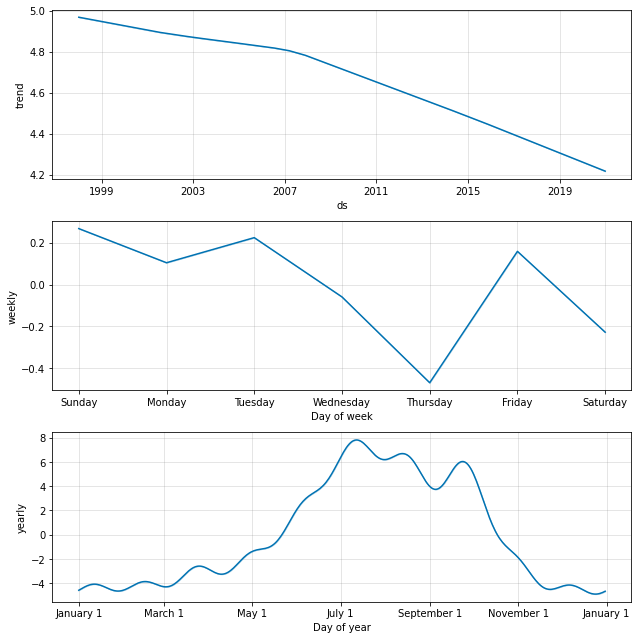

In [ ]:
### plot the predicted projection
model.plot_components(prediction)

### Weekly Prediction for another one year

In [ ]:
from datetime import datetime
weekly = df_fb
weekly['ds'] = weekly['ds'].astype('datetime64[ns]')
#convert daily data to weekly
weekly_data = weekly.resample('W-Wed', label='right', closed = 'right', on='ds').mean().reset_index().sort_values(by='ds')

In [ ]:
weekly_data

,ds,y
0,1998-01-07,0.694286
1,1998-01-14,0.167143
2,1998-01-21,0.000000
3,1998-01-28,3.870000
4,1998-02-04,0.090000
...,...,...
1143,2019-12-04,0.000000
1144,2019-12-11,0.000000
1145,2019-12-18,0.000000
1146,2019-12-25,0.000000


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


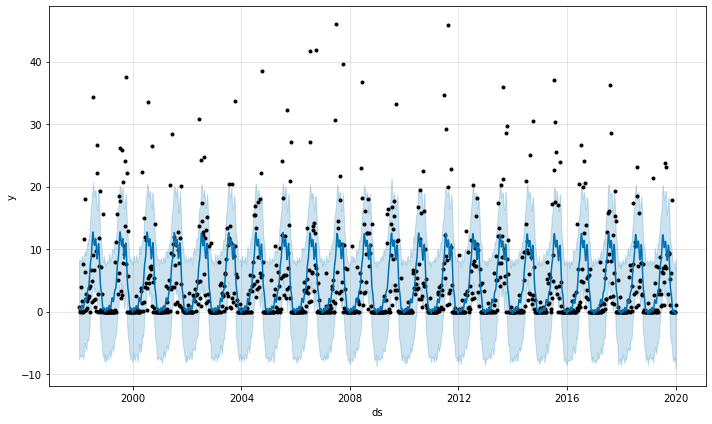

In [ ]:
m = Prophet(changepoint_prior_scale=0.01).fit(weekly_data)
future = m.make_future_dataframe(periods=52, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

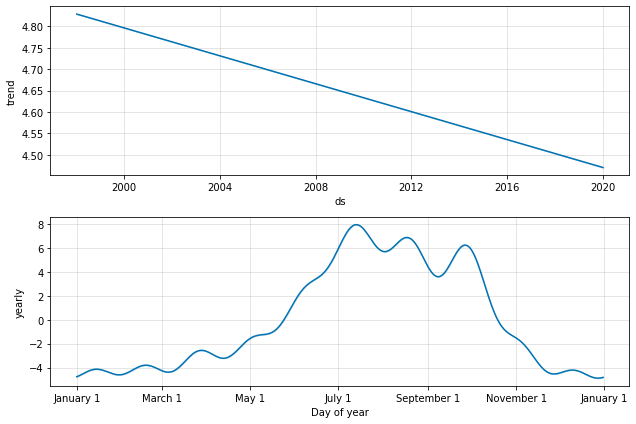

In [ ]:
fig = m.plot_components(fcst)

#### Testing Accuracy

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '400 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-11-25 00:00:00 and 2018-11-25 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-26,-0.079380,-17.330114,16.691542,0.0,2018-11-25
1,2018-11-27,0.016788,-17.291314,16.306897,0.0,2018-11-25
2,2018-11-28,-0.313401,-16.590114,17.162564,0.0,2018-11-25
3,2018-11-29,-0.625747,-17.956615,16.588370,0.0,2018-11-25
4,2018-11-30,-0.031616,-16.290453,16.774262,0.0,2018-11-25


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,40 days,1.653217,1.285775,0.680501,inf,1.0
1,41 days,1.658993,1.288019,0.690696,inf,1.0
2,42 days,1.659431,1.288189,0.693614,inf,1.0
3,43 days,1.657090,1.287280,0.687468,inf,1.0
4,44 days,1.648053,1.283765,0.676161,inf,1.0


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


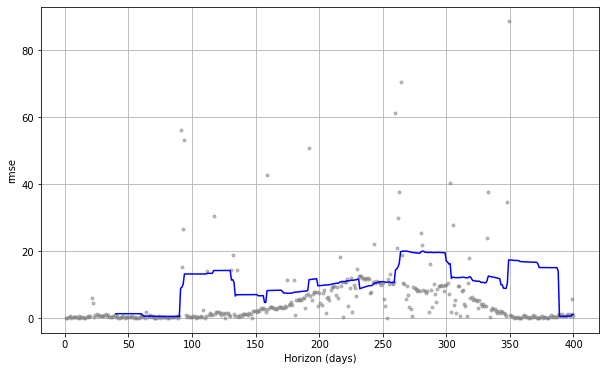

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## MODEL 2: LSTM

##### Library Import

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##### Data Loading

In [ ]:
training_set = df.copy()

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

##### Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

##### Training

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.23260
Epoch: 100, loss: 0.00371
Epoch: 200, loss: 0.00354
Epoch: 300, loss: 0.00344
Epoch: 400, loss: 0.00340
Epoch: 500, loss: 0.00338
Epoch: 600, loss: 0.00337
Epoch: 700, loss: 0.00336
Epoch: 800, loss: 0.00336
Epoch: 900, loss: 0.00335
Epoch: 1000, loss: 0.00334
Epoch: 1100, loss: 0.00333
Epoch: 1200, loss: 0.00333
Epoch: 1300, loss: 0.00332
Epoch: 1400, loss: 0.00332
Epoch: 1500, loss: 0.00331
Epoch: 1600, loss: 0.00331
Epoch: 1700, loss: 0.00330
Epoch: 1800, loss: 0.00330
Epoch: 1900, loss: 0.00330


##### Testing

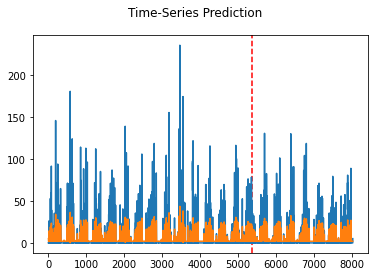

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Red line showing TEST-TRAIN Split

## Model 3: Arima/Sarimax Monthly Prediction

##### Loading Data

In [ ]:
DF = df.copy()
DF

,Rainfall
1998-01-01,0.0000
1998-01-02,0.0000
1998-01-03,0.0000
1998-01-04,4.8600
1998-01-05,0.0000
...,...
2019-12-26,0.0000
2019-12-27,0.0000
2019-12-28,0.0000
2019-12-29,5.0818


In [ ]:
DF.index = pd.to_datetime(DF.index)

In [ ]:
### Creating Monthly Distribution
DF = DF.resample('MS').mean()
DF

,Rainfall
1998-01-01,1.088710
1998-02-01,2.312825
1998-03-01,8.121745
1998-04-01,1.242717
1998-05-01,2.431732
...,...
2019-08-01,13.814080
2019-09-01,9.047193
2019-10-01,5.160934
2019-11-01,4.150120


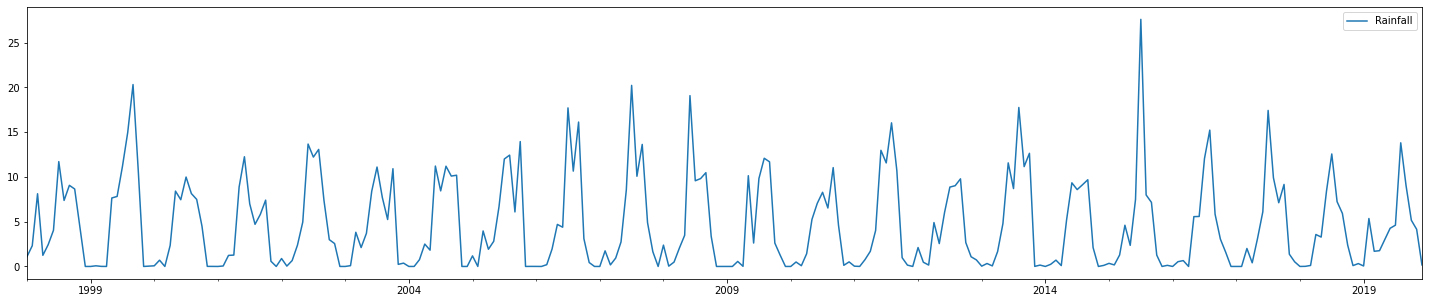

In [ ]:
DF.plot(figsize=(25,5))

In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(DF['Rainfall'])

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(rainrate):
    result=adfuller(rainrate)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(DF['Rainfall'])

ADF Test Statistic : -4.385499554992422
p-value : 0.00031487205419073995
#Lags Used : 14
Number of Observations Used : 249
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


###### Differencing

In [ ]:
DF['Rainrate First Difference'] = DF['Rainfall'] - DF['Rainfall'].shift(1)

In [ ]:
DF['Seasonal First Difference']=DF['Rainfall'] - DF['Rainfall'].shift(12)

In [ ]:
DF.head(14)

,Rainfall,Rainrate First Difference,Seasonal First Difference
1998-01-01,1.088710,NaN,NaN
1998-02-01,2.312825,1.224115,NaN
1998-03-01,8.121745,5.808920,NaN
1998-04-01,1.242717,-6.879028,NaN
1998-05-01,2.431732,1.189015,NaN
1998-06-01,4.037945,1.606213,NaN
1998-07-01,11.713133,7.675187,NaN
1998-08-01,7.377103,-4.336029,NaN
1998-09-01,9.062887,1.685783,NaN
1998-10-01,8.652316,-0.410571,NaN


In [ ]:
## Again test dickey fuller test
adfuller_test(DF['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.412609061588075
p-value : 7.069200580308949e-11
#Lags Used : 14
Number of Observations Used : 237
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


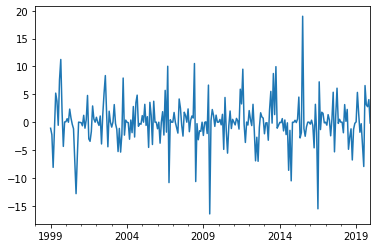

In [ ]:
DF['Seasonal First Difference'].plot()

#### Auto Regressive Model

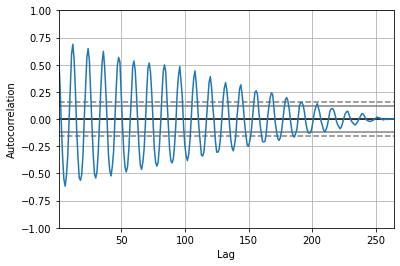

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(DF['Rainfall'])
plt.show()


#####Autocorrelation and Partial Autocorrelation

    Identification of an AR model is often best done with the PACF.
        For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

    Identification of an MA model is often best done with the ACF rather than the PACF.

        For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

        p,d,q p AR model lags d differencing q MA lags



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

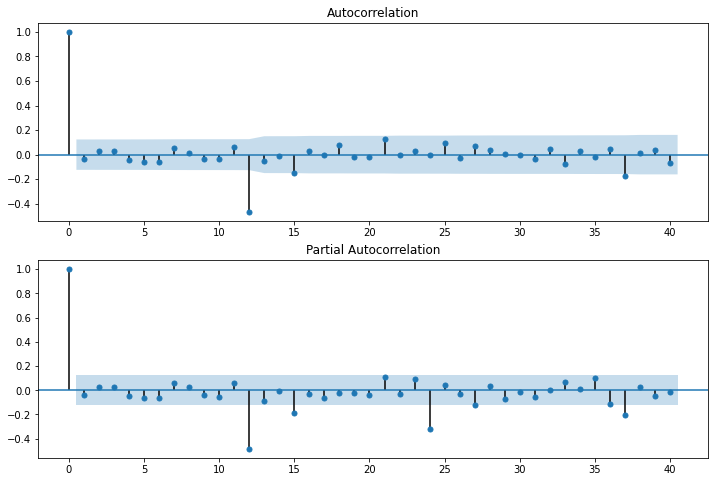

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(DF['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(DF['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model=ARIMA(DF['Rainfall'],order=(1,0,1))  #Earlier it was (1,1,1)
model_fit=model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Rainfall   No. Observations:                  264
Model:                     ARMA(1, 1)   Log Likelihood                -750.600
Method:                       css-mle   S.D. of innovations              4.152
Date:                Wed, 16 Feb 2022   AIC                           1509.200
Time:                        09:45:24   BIC                           1523.503
Sample:                    01-01-1998   HQIC                          1514.947
                         - 12-01-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6211      0.580      7.963      0.000       3.484       5.759
ar.L1.Rainfall     0.5421      0.074      7.348      0.000       0.398       0.687
ma.L1.Rainfall     0.0447      0.077      0.584      0.560      -0.105       0.195
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8447           +0.0000j            1.8447            0.0000
MA.1          -22.3734           +0.0000j           22.3734            0.5000
-----------------------------------------------------------------------------
"""

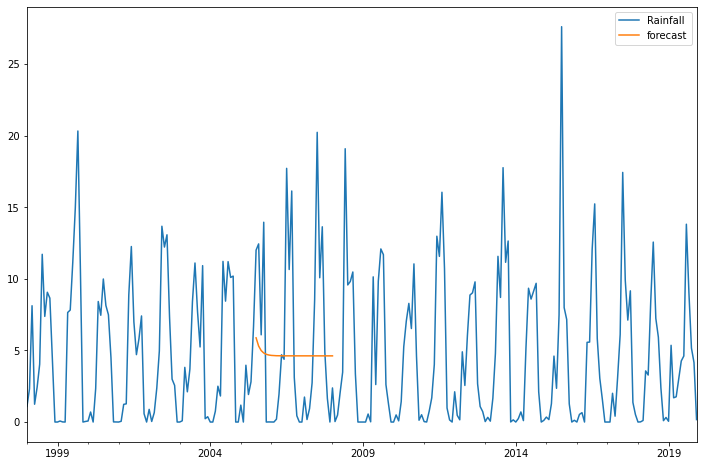

In [ ]:
DF['forecast']=model_fit.predict(start=90,end=120,dynamic=True)
DF[['Rainfall','forecast']].plot(figsize=(12,8))

Therefore, ARIMAX is not suitable for seasonal data

#### Sarimax

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(DF['Rainfall'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

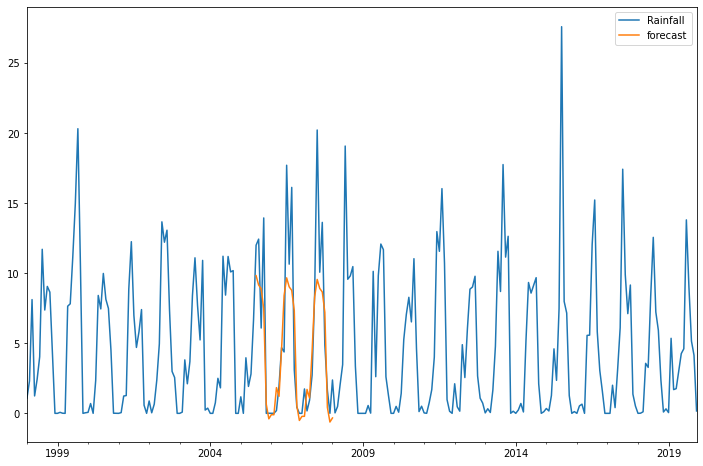

In [ ]:
DF['forecast']=results.predict(start=90,end=120,dynamic=True)
DF[['Rainfall','forecast']].plot(figsize=(12,8))

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[DF.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=DF.columns)

In [ ]:
future_datest_df.tail()

,Rainfall,Rainrate First Difference,Seasonal First Difference,forecast
2021-07-01,NaN,NaN,NaN,NaN
2021-08-01,NaN,NaN,NaN,NaN
2021-09-01,NaN,NaN,NaN,NaN
2021-10-01,NaN,NaN,NaN,NaN
2021-11-01,NaN,NaN,NaN,NaN


In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 1998-01-01 to 2019-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rainfall                   264 non-null    float64
 1   Rainrate First Difference  263 non-null    float64
 2   Seasonal First Difference  252 non-null    float64
 3   forecast                   31 non-null     float64
dtypes: float64(4)
memory usage: 18.4 KB


In [ ]:
future_df=pd.concat([DF,future_datest_df])

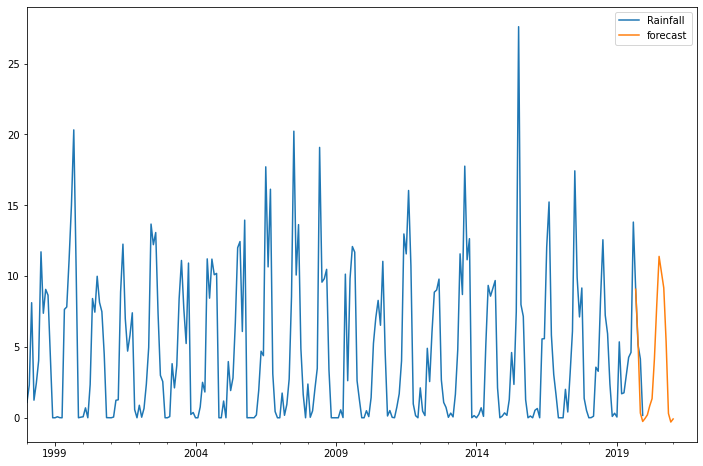

In [ ]:
future_df['forecast'] = results.predict(start = 260, end = 276, dynamic= True)
future_df[['Rainfall', 'forecast']].plot(figsize=(12, 8))

## LSTM - Stacked

https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887

https://github.com/krishnaik06/Stock-MArket-Forecasting/blob/master/Untitled.ipynb

In [ ]:
df

,Rainfall
1998-01-01,0.0000
1998-01-02,0.0000
1998-01-03,0.0000
1998-01-04,4.8600
1998-01-05,0.0000
...,...
2019-12-26,0.0000
2019-12-27,0.0000
2019-12-28,0.0000
2019-12-29,5.0818


**Performing a Seasonal Decomposition on the model and plot out the ETS components**

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# results = seasonal_decompose(df['Rainfall'])
# results.observed.plot(figsize=(12,2))

### Train Test Split

Train ----------1998-01 to 2014-12 --- 70%

Validation ---2015-01 to 2017-12 --- 23%

Test ----------- 2018-01 to 2019-12 --- 7%

In [ ]:
df_train = df['1998-01-01' :'2014-12-31']
df_train

,Rainfall
1998-01-01,0.00000
1998-01-02,0.00000
1998-01-03,0.00000
1998-01-04,4.86000
1998-01-05,0.00000
...,...
2014-12-27,0.00000
2014-12-28,0.00000
2014-12-29,0.00000
2014-12-30,3.56949


In [ ]:
df_validation = df['2015-01-01' :'2017-12-31']
df_validation

,Rainfall
2015-01-01,10.71
2015-01-02,0.00
2015-01-03,0.00
2015-01-04,0.00
2015-01-05,0.00
...,...
2017-12-27,0.00
2017-12-28,0.00
2017-12-29,0.00
2017-12-30,0.00


In [ ]:
df_test = df['2018-01-01' :]
df_test

,Rainfall
2018-01-01,0.0000
2018-01-02,0.0000
2018-01-03,0.0000
2018-01-04,0.0000
2018-01-05,0.0000
...,...
2019-12-26,0.0000
2019-12-27,0.0000
2019-12-28,0.0000
2019-12-29,5.0818


### Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1)) #feature_range=(0,1) ## Default
scaler.fit(df_train)   ## Will use this same scale in future

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
scaled_train = scaler.transform(df_train)

In [ ]:
scaled_validation = scaler.transform(df_validation)

In [ ]:
scaled_test = scaler.transform(df_test)

### Preparing Model

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

#### Create LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


6182/6182 [==============================] - 87s 14ms/step - loss: 0.0168
Epoch 2/30
6182/6182 [==============================] - 83s 13ms/step - loss: 0.0142
Epoch 3/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0138
Epoch 4/30
6182/6182 [==============================] - 81s 13ms/step - loss: 0.0138
Epoch 5/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0137
Epoch 6/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0136
Epoch 7/30
6182/6182 [==============================] - 81s 13ms/step - loss: 0.0136
Epoch 8/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0134
Epoch 9/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0134
Epoch 10/30
6182/6182 [==============================] - 82s 13ms/step - loss: 0.0134
Epoch 11/30
6182/6182 [==============================] - 83s 13ms/step - loss: 0.0133
Epoch 12/30
6182/6182 [==============================] - 82s 13ms/step - l

##### Plot the history of the loss that occured during training.

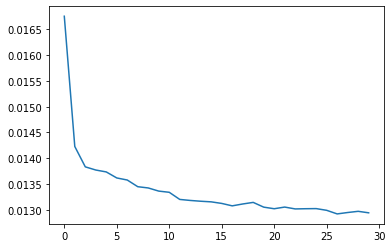

In [ ]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#### Evaluate

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-1.        ],
       [-0.96974252],
       [-1.        ]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

##### Predictions: Generate predictions into the same time stamps as the test set

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[ 0.29019371],
       [ 0.03342115],
       [-0.02517309],
       [-0.02311987],
       [-0.00383925],
       [ 0.01543434],
       [ 0.02897015],
       [ 0.03640254],
       [ 0.03927846],
       [ 0.03947534],
       [ 0.03844873],
       [ 0.03712679],
       [ 0.03594549],
       [ 0.03508763],
       [ 0.03451807],
       [ 0.03420165],
       [ 0.03404696],
       [ 0.03513685],
       [ 0.03560797],
       [ 0.03544624],
       [ 0.03463761],
       [ 0.03446885],
       [ 0.03453917],
       [ 0.03420868],
       [ 0.03413134],
       [ 0.03406102],
       [ 0.03403289],
       [ 0.03402586],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403289],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0.03403993],
       [ 0

In [ ]:
df_testX = df_validation.iloc[-n_past:,:]
df_testX

In [ ]:
### Multi-Step Prediction
testY = []
future = 729
testX = df_testX.values

while True:
  if len(testY) >= future:
    break
  test_pred = model.predict(testX) #np.array([testX])#
  testY.extend(test_pred)
  # print(testX[n_future:].shape, test_pred[0].shape)
  testX = np.append(testX[n_future:], test_pred, axis = 0)
## Adding Further Preds, stopping loop early.
testY = testY[0:future]

In [ ]:
# testY - Final Prediction
test_predY = pd.DataFrame(scaler.inverse_transform(np.array(testY)), columns=df_test.columns, index=df_test.index)
test_predY

In [ ]:
df_test

## Thank You